# Исследование стеганографических методов
Ниже представлен код реализации алгоритмов, рассмотренных в диссертации.

Для корректной работы сценариев Python должны быть установлены следующие библиотеки.

In [ ]:
# Должны быть установлены
%pip install pillow
%pip install pycryptodome
%pip install pyaes pbkdf2
%pip install bitstring

# *Простой алгоритм LSB*
Секретное сообщение будет внедрено в самый незначительный бит каждого цветового канала пикселя.

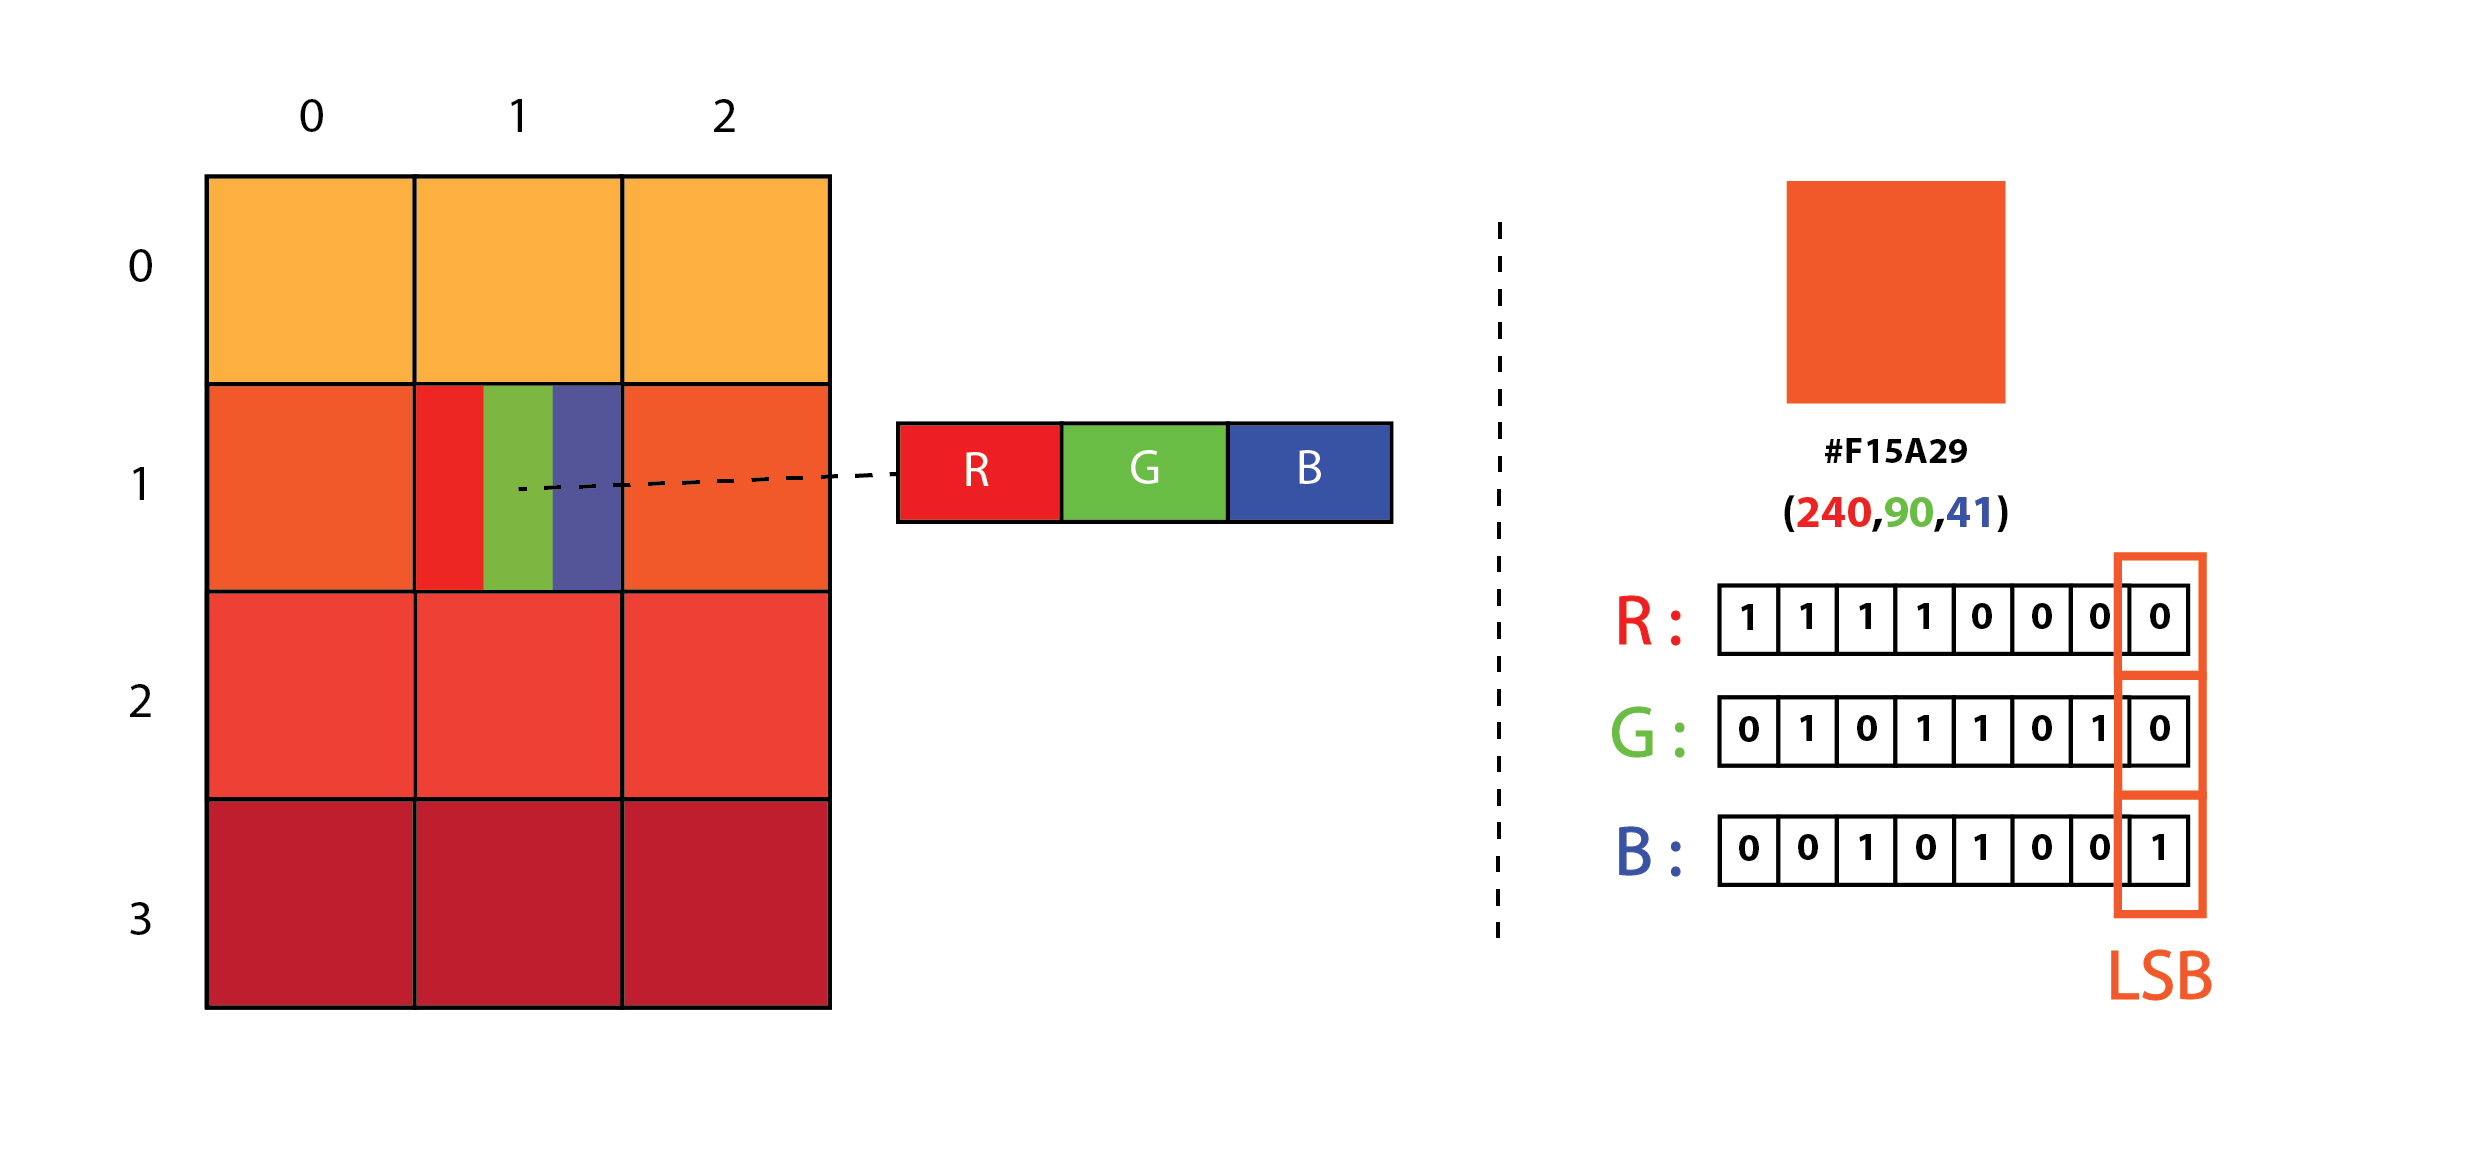

In [2]:
"""              Простой алгоритм LSB              """

from PIL import Image     # библиотека для простых операций с изображениями

# Функция, преобразующая любой тип данных в двоичный
def textToBinary(text):
		aux = []
		for i in text:
			aux.append(format(ord(i), '08b'))    # ord -> символ в Unicode; 08b -> 8-битный формат
		return aux


# Функция, кодирующая секретное сообщение в пикселях изображения
def messageInPixel(pixel, text): 
    textB = textToBinary(text)        # преобразовать секретное сообщение в двоичное
    lenTextB = len(textB) 
    iterator = iter(pixel) 
  
    # для каждого байта двоичного секретного сообщения
    for i in range(lenTextB): 
        # Извлечение 3 пикселей за раз (= 9 байт)
        pixel = [value for value in iterator.__next__() + iterator.__next__() + iterator.__next__()] 

        # Изменение значения пикселя в соответствии с секретным сообщением (для каждого бита в байте секретного сообщения)
        for j in range(0, 8): 
            # изменяет биты только в том случае, если они не совпадают (по статистике, только половину битов в изображении нужно изменить)
            if (textB[i][j] == '0') and (pixel[j] % 2 != 0): 
                pixel[j] -= 1
            elif (textB[i][j] == '1') and (pixel[j] % 2 == 0): 
                pixel[j] -= 1
                  
        # 9-й бит: 0 - продолжение чтения; 1 - остановка (все сообщение полностью закодировано)  
        if (i == lenTextB - 1): 
            if (pixel[-1] % 2 == 0): 
                pixel[-1] -= 1
        else: 
            if (pixel[-1] % 2 != 0): 
                pixel[-1] -= 1

        # возвращаем измененные пиксели, чтобы построить новое стегоизображение
        pixel = tuple(pixel) 
        yield pixel[0:3]      # по одному пикселю (3 цветовых канала)
        yield pixel[3:6] 
        yield pixel[6:9]
        

# Функция, вставляющая секретное сообщение в изображение     
def encodeAux(img, text): 
    w = img.size[0] 
    (x, y) = (0, 0) 
      
    for pixel in messageInPixel(img.getdata(), text): 
        # Помещаем измененные пиксели в изображение (построение стегобъекта)
        # "Просмотр" изображения сверху вниз слева направо (последовательно)
        img.putpixel((x, y), pixel)   # помещаем по одному пикселю (3 цветовых канала) на каждую позицию
        if (x == w - 1):              # перемещение по изображению
            x = 0
            y += 1
        else: 
            x += 1
        

# Основная функция для встраивания секретного сообщения в изображение
def encode(): 
    img = input("Insert Image with extension: ") 
    image = Image.open(img, 'r') 

    text = input("Enter Secret Message: ") 
    if (len(text) == 0): 
        raise ValueError('The secret message cannot be empty!')

    imgAux = image.copy() 
    width, height = imgAux.size

    # Проверяем, чтобы размер секретного сообщения не превышал объем изображения
    nr_bytes = width * height * 3 // 8
    if (nr_bytes < len(text)):
      raise ValueError(f"Insufficient bytes: choose a larger picture or reduce the message size!\nMaximum number of bytes: {nr_bytes}")
    else:
      encodeAux(imgAux, text) 

    newImg = input("Enter New Picture Name with extension: ") 
    imgAux.save(newImg, str(newImg.split(".")[1].upper()))


# Основная функция, позволяющая извлечь секретное сообщение из изображения
def decode(): 
    img = input("Insert Image with extension: ") 
    image = Image.open(img, 'r') 

    text = '' 
    imgdata = iter(image.getdata()) 

    while (True): 
        pixels = [value for value in imgdata.__next__() + imgdata.__next__() + imgdata.__next__()] 
        # Битовая строка
        binstr = '' 

        # Интересуют первые 8 байт (9-й - дошел ли до конца или нет) 
        for i in pixels[:8]: 
            if (i % 2 == 0): 
                binstr += '0'
            else: 
                binstr += '1'
                  
        text += chr(int(binstr, 2))   # chr -> возврат символа из юникода
        # Если был достигнут конец секретного сообщения ( = 1)
        if (pixels[-1] % 2 != 0): 
            return text
        

# Простой алгоритм LSB  
def LSB_Simple(): 
    choice = int(input(":::    Simple LSB    :::\n"
                        "1. Encoding\n2. Decoding\n")) 
    
    if (choice == 1): 
        encode()     
    elif (choice == 2): 
        print("Secret Message: " + decode()) 
    else: 
        raise Exception("Incorrect input!")
    

LSB_Simple()

ValueError: invalid literal for int() with base 10: ''

# *Алгоритм LSB через связные списки*
Этот метод вносит несколько важных улучшений в базовый алгоритм. Во-первых, секретное сообщение больше не встраивается в последовательные пиксели, а используется концепция связного списка: в красный канал пикселя встраивается секретное сообщение, в зеленый канал - координата X для позиции следующего пикселя, а в синий - координата Y следующего пикселя. Чтобы декодировать сообщение, нам нужна позиция первого пикселя (как и адрес корня связного списка).

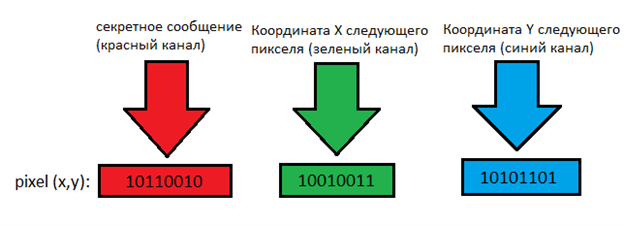

In [ ]:
"""              Алгоритм LSB через связные списки              """

from PIL import Image
import binascii               # операции между двоичным кодом и ASCII
from random import choice     # для генерации случайных чисел


def nrPixelInCoordinate(nr, img):
    """
        We return the pixel coordinates in the img image, starting from the pixel number.
        Ex: img has L = 10, l = 5 and we are interested in pixel 11
        ---> Coordinates: (1, 0)
    """
    return (nr%img.size[0], nr//img.size[0])


def coordinateInNrPixel(x, y, img):
    # Обратная операция функции выше
    return int(y * img.size[0] + x)


# Изменение LSB в соответствии с секретным сообщением (двоичное)
def setLSB(pix, dateSecret):
    if dateSecret == "0":
        return pix & 0b11111110
    elif dateSecret == "1":
        return pix | 0b00000001


# Текст в двоичном виде
def textToBinary(text):
    return ''.join(format(ord(x), '08b') for x in text)


# Деление на блоки
def chunkstring(text, lungime):
    return [text[0+i:lungime+i].ljust(lungime, "0") for i in range(0, len(text), lungime)]


def encodeAux(text, pixel, nextP, img):
    pix = img.load()
    x, y = nrPixelInCoordinate(nextP, img)
    l = len(text)
    # Координата x для nextP в двоичном формате
    col = bin(x)[2:].zfill(l)               # bin -> ставит 0b перед двоичным значением, так что выводим его
    # координата y для nextP в двоичном формате
    lin = bin(y)[2:].zfill(l)
    
    # берем последовательные пиксели для кодирования байта (переходим к другому пикселю для нового байта)
    for i in range(pixel, pixel + l):
        p = pix[nrPixelInCoordinate(i, img)]
        pix[nrPixelInCoordinate(i, img)] = (
            setLSB(p[0], text[i-pixel]),
            setLSB(p[1], col[i-pixel]),
            setLSB(p[2], lin[i-pixel]))


def encode(text, imgIn, imgOut, startingPixel=(0,0)):
    img = Image.open(imgIn)
    # выбираем больший размер блока (в зависимости от изображения) для лучшего времени
    BLOCKLEN = len(bin(max(img.size))[2:])
    total = img.size[0] * img.size[1]
    # список свободных блоков пикселей
    AVAILABLE = [x for x in range(1, total-1, BLOCKLEN)]
    # проверяем достаточно ли большой последний блок
    if AVAILABLE[-1] + BLOCKLEN >= total:
        AVAILABLE.pop()

    d = chunkstring(textToBinary(text), BLOCKLEN)
    n = len(d)
    # первый пиксель по заданным координатам
    pixel = coordinateInNrPixel(startingPixel[0], startingPixel[1], img)
    if pixel == 0:
        # (0, 0) не может быть первым пикселем
        pixel = choice(AVAILABLE)
        AVAILABLE.remove(pixel)
        startingPixel = nrPixelInCoordinate(pixel, img)
    for i in range(n-1):
        # указатель на следующий пиксель
        nextP = choice(AVAILABLE)
        AVAILABLE.remove(nextP)
        encodeAux(d[i], pixel, nextP, img)
        # переход к следующему пикселю
        pixel = nextP
    # последний указатель, возвращающий NULL (0, 0)
    encodeAux(d[n-1], pixel, 0, img)
    img.save(imgOut)
    img.close()
    # нужен "корневой" пиксель
    return startingPixel


def binaryToText(text):
    # убеждаемся, что текст кратен 8 битам
    # иначе ставим внутренние отступы по-другому
    if len(text) % 8 != 0:
        r = 8 - (len(text) % 8)
        text = text + "0" * r
    
    h = hex(int(text, 2))[2:]
    if len(h) % 2 != 0:
        h = "0" + h
    # удаляем последний NULL-байт (тот, который указывает на конец)
    return binascii.unhexlify(h)[:-1]     # Для unhexlify требуется четное число символов 


def decodeAux(img, startX, startY):
    n = coordinateInNrPixel(startX, startY, img)
    pix = img.load()
    BLOCKLEN = len(bin(max(img.size))[2:])
    nx = ""
    ny = ""
    s = ""
    for i in range(BLOCKLEN):
        c = nrPixelInCoordinate(n+i, img)
        s += str(pix[c][0] & 1)
        nx += str(pix[c][1] & 1)
        ny += str(pix[c][2] & 1)
    nx = int(nx, 2)
    ny = int(ny, 2)
    return (s,(nx, ny))


def decode(imgName, startX, startY):
    img = Image.open(imgName)
    data, p = decodeAux(img, startX, startY)
    while p != (0, 0):
        d, p = decodeAux(img, p[0], p[1])
        data += d
    d, p = decodeAux(img, p[0], p[1])
    data += d
    return binaryToText(data)


# Алгоритм LSB со связными списками
def LSB_List(): 
    choice = int(input(":::    LSB List    :::\n"
                        "1. Encoding\n2. Decoding\n")) 
    
    if (choice == 1): 
        img = input("Insert Image with extension: ") 

        text = input("Enter Secret Message: ") 
        if (len(text) == 0): 
            raise ValueError('The secret message cannot be empty!')
        
        newImg = input("Enter the New Picture Name with extension: ") 
        
        r = encode(text, img, newImg)  
        print(f"Secret Key: {r}")
        
    elif (choice == 2): 
        img = input("Insert Image with extension: ") 
        x = input("Enter the X coordinate of the key: ") 
        y = input("Enter the Y coordinate of the key: ") 
        print(decode(img, int(x), int(y))) 
        
    else: 
        raise Exception("Incorrect input!")
    

LSB_List()

# *Алгоритм LSB с использованием кластеризации K-средних*
К изображению-обложке применяется алгоритм K-средних, в результате чего формируется 3 кластера (можно выбрать большее количество кластеров, если сообщение большое или мы хотим создать путаницу). Пиксели распределяются по трем кластерам, которые в дальнейшем преобразуются в самостоятельные изображения. На следующем этапе секретное сообщение шифруется и делится на три фрагмента равной длины; каждому фрагменту присваивается изображение и кодируется в нем с помощью техники LSB. Важно отметить, что цвета распределены неравномерно, и ожидается, что некоторые кластеры будут больше, чем другие. Таким образом, если у нас есть сообщение большого размера и мы разбиваем его на три равных фрагмента, как описано в оригинальном алгоритме, мы можем потерять переданное сообщение, поэтому возможным улучшением было бы разбиение сообщения на три фрагмента, прямо пропорциональных размеру трех полученных кластеров.

In [ ]:
"""              Алгоритм LSB с использованием кластеризации K-средних              """

import cv2           # для работы с изображениями
import numpy as np
import math
from PIL import Image

def KMeansClustering(poza):
  img = cv2.imread(poza)
  Img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    # cv2 считывает каналы в обратном порядке и нужно вернуть их по порядку

  # Официальное учебное пособие по K-средним : https://docs.opencv.org/3.4/d1/d5c/tutorial_py_kmeans_opencv.html
  """
      Input parameters
        samples : It should be of np.float32 data type, and each feature should be put in a single column.
        nclusters(K) : Number of clusters required at end
        criteria : It is the iteration termination criteria. When this criteria is satisfied, algorithm iteration stops. Actually, it should be a tuple of 3 parameters. They are `( type, max_iter, epsilon )`:
        type of termination criteria. It has 3 flags as below:
        cv.TERM_CRITERIA_EPS - stop the algorithm iteration if specified accuracy, epsilon, is reached.
        cv.TERM_CRITERIA_MAX_ITER - stop the algorithm after the specified number of iterations, max_iter.
        cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER - stop the iteration when any of the above condition is met.
        max_iter - An integer specifying maximum number of iterations.
        epsilon - Required accuracy
        attempts : Flag to specify the number of times the algorithm is executed using different initial labellings. The algorithm returns the labels that yield the best compactness. This compactness is returned as output.
        flags : This flag is used to specify how initial centers are taken. Normally two flags are used for this : cv.KMEANS_PP_CENTERS and cv.KMEANS_RANDOM_CENTERS.

      Output parameters
        compactness : It is the sum of squared distance from each point to their corresponding centers.
        labels : This is the label array (same as 'code' in previous article) where each element marked '0', '1'.....
        centers : This is array of centers of clusters.
  """
  vector_img = Img.reshape((-1, 3))      # вектор с 3 столбцами
  vector_img = np.float32(vector_img)    # согласно официальной документации
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1.0)
  compactness, labels, centers = cv2.kmeans(vector_img, 3, None, criteria, 10, cv2.KMEANS_PP_CENTERS)

  # сохраняем новое изображение после применения алгоритма кластеризации K-Means
  centers = np.uint8(centers)
  res = centers[labels]
  res_image = res.reshape((Img.shape))
  clustered_img = Image.fromarray(res_image)
  clustered_img.save('clustered_img.png')

  # 3 изображения соответствующих 3 кластерам (в которых мы спрячем секретное сообщение)
  # разделим пиксели на 3 соответствующих кластера
  image_one_array = []
  image_two_array = []
  image_three_array = []
  for i in range(0, len(labels)):
    if labels[i][0] == 0:
      image_one_array.append(vector_img[i])
    elif labels[i][0] == 1:
      image_two_array.append(vector_img[i])
    else:
      image_three_array.append(vector_img[i])
    
  len1 = len(image_one_array)
  len2 = len(image_two_array)
  len3 = len(image_three_array)

  pad1 = math.ceil(math.sqrt(len1))**2 - len1
  pad2 = math.ceil(math.sqrt(len2))**2 - len2
  pad3 = math.ceil(math.sqrt(len3))**2 - len3

  # внутренние отступы для изображений
  white = np.array([255.0, 255.0, 255.0], dtype=np.float32)

  for i in range(0, pad1): image_one_array.append(white)
  for i in range(0, pad2): image_two_array.append(white)
  for i in range(0, pad3): image_three_array.append(white)

  d1 = int(math.sqrt(len(image_one_array)))
  d2 = int(math.sqrt(len(image_two_array)))
  d3 = int(math.sqrt(len(image_three_array)))

  cluster1 = np.uint8(np.array(image_one_array)).reshape((d1, d1, 3))
  cluster2 = np.uint8(np.array(image_two_array)).reshape((d2, d2, 3))
  cluster3 = np.uint8(np.array(image_three_array)).reshape((d3, d3, 3))

  # сохраняем изображения (кластеры), на которых будем кодировать секретное сообщение
  cluster1_img = Image.fromarray(cluster1)
  cluster1_img.save('cluster1_img.png')

  cluster2_img = Image.fromarray(cluster2)
  cluster2_img.save('cluster2_img.png')

  cluster3_img = Image.fromarray(cluster3)
  cluster3_img.save('cluster3_img.png')


#######             Простой LSB             #######
# Функция, преобразующая любой тип данных в двоичный
def textToBinary(text):
		aux = []
		for i in text:
			aux.append(format(ord(i), '08b'))    # ord -> символ в Unicode; 08b -> 8-битный формат
		return aux


# Функция, кодирующая секретное сообщение в пикселях изображения
def messageInPixel(pixel, text): 
    textB = textToBinary(text)        # преобразуем секретное сообщение в двоичное
    lenTextB = len(textB) 
    iterator = iter(pixel) 
  
    # для каждого байта двоичного секретного сообщения
    for i in range(lenTextB): 
        # Извлечение 3 пикселей за раз (= 9 байт)
        pixel = [value for value in iterator.__next__() + iterator.__next__() + iterator.__next__()] 

        # Изменение значения пикселя в соответствии с секретным сообщением (для каждого бита в байте секретного сообщения)
        for j in range(0, 8): 
            # изменяет биты только в том случае, если они не совпадают (по статистике, только половину битов в изображении нужно изменить)
            if (textB[i][j] == '0') and (pixel[j] % 2 != 0): 
                pixel[j] -= 1
            elif (textB[i][j] == '1') and (pixel[j] % 2 == 0): 
                pixel[j] -= 1
                  
        # 9-й бит: 0 - продолжение чтения; 1 - остановка (все сообщение полностью закодировано)  
        if (i == lenTextB - 1): 
            if (pixel[-1] % 2 == 0): 
                pixel[-1] -= 1
        else: 
            if (pixel[-1] % 2 != 0): 
                pixel[-1] -= 1

        # возвращаем измененные пиксели для создания нового стегоизображения
        pixel = tuple(pixel) 
        yield pixel[0:3]      # по одному пикселю (3 цветовых канала)
        yield pixel[3:6] 
        yield pixel[6:9]
        

# Функция встраивающая секретное сообщение в изображение 
def encodeAux(img, text): 
    w = img.size[0] 
    (x, y) = (0, 0) 
      
    for pixel in messageInPixel(img.getdata(), text): 
        # помещаем измененные пиксели в изображение (построение стегобъекта)
        # "Просмотр" изображения сверху вниз слева направо (последовательно)
        img.putpixel((x, y), pixel)   # помещаем по одному пикселю (3 цветовых канала) на каждую позицию
        if (x == w - 1):              # перемещение по изображению
            x = 0
            y += 1
        else: 
            x += 1
            

# Основная функция для встраивания секретного сообщения в изображение
def encode(picture, text, pictureFinal): 
    image = Image.open(picture, 'r') 
    imgAux = image.copy() 
    width, height = imgAux.size

    # Проверяем, чтобы размер секретного сообщения не превышал объем изображения
    nr_bytes = width * height * 3 // 8
    if (nr_bytes < len(text)):
      raise ValueError(f"Insufficient bytes: choose a larger picture or reduce the message size!\nMaximum number of bytes: {nr_bytes}")
    else:
      encodeAux(imgAux, text) 

    imgAux.save(pictureFinal, str(pictureFinal.split(".")[1].upper()))


# Основная функция, позволяющая извлечь секретное сообщение из изображения
def decode(img): 
    image = Image.open(img, 'r') 

    text = '' 
    imgdata = iter(image.getdata()) 

    while (True): 
        pixels = [value for value in imgdata.__next__() + imgdata.__next__() + imgdata.__next__()] 
        # Битовая строка
        binstr = '' 

        # Интересуют первые 8 байт (9-й - дошел ли до конца или нет) 
        for i in pixels[:8]: 
            if (i % 2 == 0): 
                binstr += '0'
            else: 
                binstr += '1'
                  
        text += chr(int(binstr, 2))   # chr -> возвращает символ из юникода
        # Если достигли конца секретного сообщения ( = 1)
        if (pixels[-1] % 2 != 0): 
            return text


# Алгоритм LSB с использованием кластеризации K-средних
def LSB_KMeans(): 
    choice = int(input(":::    LSB K-means clustering    :::\n"
                        "1. Encoding\n2. Decoding\n")) 
    
    if (choice == 1): 
        img = input("Insert Image with extension: ") 
        KMeansClustering(img)

        text = input("Enter Secret Message: ") 
        if (len(text) == 0): 
            raise ValueError('The secret message cannot be empty!')
        # делим сообщение на 3 равные части (рекомендуется делить прямо пропорционально размеру кластера)
        div_len = int(len(text)//3)
        chunk1 = text[0:div_len]
        chunk2 = text[div_len: 2*div_len]
        chunk3 = text[2*div_len:]

        image_encoded1 = encode('cluster1_img.png', chunk1, 'a.png')
        image_encoded2 = encode('cluster2_img.png', chunk2, 'b.png')
        image_encoded3 = encode('cluster3_img.png', chunk3, 'c.png')
        

    elif (choice == 2): 
        decoded_chunk1 = decode('a.png')
        decoded_chunk2 = decode('b.png')
        decoded_chunk3 = decode('c.png')

        messageSecret = decoded_chunk1 + decoded_chunk2 + decoded_chunk3
        print("Secret message: ", messageSecret)
        
    else: 
        raise Exception("Incorrect input!")
    

LSB_KMeans()

# *Предложенный алгоритм LSB: AES и случайные пиксели*
Ниже предложен алгоритм стеганографии, основанный на технике LSB. Выбор этой методики обусловлен тем, что в литературе хорошо известно, что стеганографический алгоритм, использующий LSB, более уязвим, чем другие техники. 

> Логичным первым шагом является шифрование сообщения. Таким образом, осуществляется связь между криптографией и стеганографией, и безопасность алгоритма существенно повышается. Для шифрования секретного сообщения был использован алгоритм AES - быстрый симметричный алгоритм, который выполняется без потери определенных данных в памяти.

> Далее, чтобы повысить безопасность алгоритма LSB, будем считать, что он слаб против атак стеганализа из-за того, что модифицированные пиксели размещаются последовательно. Поэтому предлагается перетасовать их, чтобы использовать весь потенциал изображения обложки и повысить безопасность. Для этого была использована современная версия алгоритма тасования Фишера-Йетса версияи Дурштенфельда.

Предложенный метод не очень эффективен с точки зрения памяти, поскольку приходится передавать зашифрованную последовательность пикселей вместе с результирующим стегоизображением, но следует пойти на этот компромисс, чтобы добиться большей безопасности.





In [7]:
"""              Предлагаемый Алгоритм LSB              """

import os         
import binascii
import pbkdf2
import pyaes
import hashlib
import random
import numpy as np
from PIL import Image
import struct
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes


########################################      ШИФРОВАНИЕ + ДЕШИФРОВАНИЕ СООБЩЕНИЯ
# https://cryptobook.nakov.com/symmetric-key-ciphers/aes-encrypt-decrypt-examples
# должны быть одинаковыми для шифрования и дешифрования
passwordSalt = b'\\`\xd6\xdaB\x03\xdd\xd4z\xb6p\xe8O\xf0\xa8\xc0'
iv = 12276418801510358845029257473125458269416880639997527613362129559241916371076
def encrypt(text, password):
    """
        Derives a 256-bit key using the PBKDF2 key derivation algorithm from the password. It uses a random 
        password derivation salt (128-bit). This salt should be stored in the output, together with the ciphertext, 
        because without it the decryption key cannot be derived again and the decryption will be impossible.
        The derived key consists of 64 hex digits (32 bytes), which represents a 256-bit integer number.
    """
    key = pbkdf2.PBKDF2(password, passwordSalt).read(32)  
    aes = pyaes.AESModeOfOperationCTR(key, pyaes.Counter(iv))
    cipherByte = aes.encrypt(text)
    return binascii.hexlify(cipherByte).decode('utf-8')   # hex цифры

def decrypt(text, password):
    res = bytes(text, 'utf-8')
    cipherByte = binascii.unhexlify(res)
    key = pbkdf2.PBKDF2(password, passwordSalt).read(32)
    aes = pyaes.AESModeOfOperationCTR(key, pyaes.Counter(iv))
    originalByte = aes.decrypt(cipherByte)
    return originalByte.decode('utf-8')


#################################      ШИФРОВАНИЕ + ДЕШИФРОВАНИЕ ФАЙЛА ПИКСЕЛЕЙ
# https://www.novixys.com/blog/using-aes-encryption-decryption-python-pycrypto/
def encrypt_file(key, in_filename, out_filename=None, chunksize=64 * 1024):
    if not out_filename:
        out_filename = in_filename + '.enc'
    iv = get_random_bytes(AES.block_size)
    encryptor = AES.new(key, AES.MODE_CBC, iv)
    filesize = os.path.getsize(in_filename)
    with open(in_filename, 'rb') as infile:
        with open(out_filename, 'wb') as outfile:
            outfile.write(struct.pack('<Q', filesize))
            outfile.write(iv)
            while True:
                chunk = infile.read(chunksize)
                if len(chunk) == 0:
                    break
                elif len(chunk) % 16 != 0:
                    chunk += b' ' * (16 - len(chunk) % 16)

                outfile.write(encryptor.encrypt(chunk))


def decrypt_file(key, in_filename, out_filename=None, chunksize=24 * 1024):
    if not out_filename:
        out_filename = os.path.splitext(in_filename)[0]
    with open(in_filename, 'rb') as infile:
        origsize = struct.unpack('<Q', infile.read(struct.calcsize('Q')))[0]
        iv = infile.read(16)
        decryptor = AES.new(key, AES.MODE_CBC, iv)
        with open(out_filename, 'wb') as outfile:
            while True:
                chunk = infile.read(chunksize)
                if len(chunk) == 0:
                    break
                outfile.write(decryptor.decrypt(chunk))

            outfile.truncate(origsize)



# Функция, преобразующая любой тип данных в двоичный
def textToBinary(text):
    binary = list(format(c, '08b') for c in bytearray(text.encode('latin-1')))
    return binary


def PixelsRandom(width, height, lenEncodedMessage):
    new = []
    Pixels = []
    for i in range(width * height):
        new.append(i)
    for i in range(len(new) - 1, 0, -1):
        j = random.randint(0, i + 1)
        new[i], new[j] = new[j], new[i]
    for i in range(lenEncodedMessage * 3):
        Pixels.append(new[i])
    vectorPixels = np.array(Pixels)
    np.savetxt("pixelsSequence.txt", vectorPixels, delimiter="\t")
    return Pixels


def encodeAux(imgAux, encodedMessage): 
    width, height = imgAux.size
    # создаем последовательность смешанных пикселей
    Pixels = PixelsRandom(width, height, len(encodedMessage))
    textB = textToBinary(encodedMessage)  
    dr = 0
    for i in range(0, len(encodedMessage) * 3, 3):
        dc = 0
        for j in range(0, 3):
            rr = Pixels[i + j] // height
            rc = Pixels[i + j] % height
            rgb = imgAux.getpixel((rr, rc))
            value = []
            idx = 0
            for k in rgb:
                if (k % 2 == 0 and textB[dr][dc] == '1'):
                    if (k == 0):
                        k += 1
                    else:
                        k -= 1
                if (k % 2 == 1 and textB[dr][dc] == '0'):
                    k -= 1
                value.append(k)
                idx += 1
                dc += 1
                if (dc >= 8):
                    break
            if (dc >= 8):
                value.append(rgb[2])
            newrgb = (value[0], value[1], value[2])
            imgAux.putpixel((rr, rc), newrgb)
        dr += 1
    
    newImg = input("Enter New Picture Name with extension: ") 
    imgAux.save(newImg, str(newImg.split(".")[1].upper()))
    passPix = input("Password For Pixels: ")
    # для проверки достоверности ключа
    key = hashlib.sha256(passPix.encode()).digest()
    encrypt_file(key, 'pixelsSequence.txt')
         

# Основная функция кодирования
def encode(): 
    img = input("Insert Image with extension: ") 
    image = Image.open(img, 'r') 

    text = input("Enter Secret Message: ") 
    if (len(text) == 0): 
        raise ValueError('The secret message cannot be empty!') 
    
    # пароль к сообщению
    passwordText = input("Password for message: ")
    encodedMessage = encrypt(text, passwordText)    # шифруем текст с помощью заданного пароля

    imgAux = image.copy() 
    width, height = imgAux.size

    # проверяем, чтобы размер секретного сообщения не превышал объем изображения
    nr_bytes = width * height * 3 // 8
    if (nr_bytes < len(text)):
      raise ValueError(f"Insufficient bytes: choose a larger picture or reduce the message size!\nMaximum number of bytes: {nr_bytes}")
    else:
      encodeAux(imgAux, encodedMessage)



# Основная функция декодирования
def decode(): 
    passPix = input("Password for Pixels: ")
    key = hashlib.sha256(passPix.encode()).digest()
    decrypt_file(key, 'pixelsSequence.txt.enc', 'out.txt')
    Pixels = np.genfromtxt('out.txt', delimiter='\t')

    if os.path.exists("out.txt"):
        os.remove("out.txt")
    if os.path.exists("pixelsSequence.txt.enc"):
        os.remove("pixelsSequence.txt.enc")

    decodedTextInBits = []
    imgOut = input("Insert Stego image with extension: ") 
    img = Image.open(imgOut, 'r') 
    width, height = img.size
    for i in range(0, len(Pixels), 3):
        ithChar = ""
        for j in range(0, 3):
            rr = Pixels[i + j] // height
            rc = Pixels[i + j] % height
            rgb = img.getpixel((rr, rc))
            for k in rgb:
                if (k & 1):
                    ithChar += '1'
                else:
                    ithChar += '0'

        ithChar = ithChar[:-1]
        decodedTextInBits.append((ithChar))
    decodedText = ''
    for i in decodedTextInBits:
        decodedText += chr(int(i, 2))
    return decodedText


# Предлагаемый алгоритм LSB
def LSB_Proposed(): 
    choice = int(input(":::    LSB Proposed   :::\n"
                        "1. Encoding\n2. Decoding\n")) 
    
    if (choice == 1): 
        encode()

    elif (choice == 2): 
      if os.path.exists("pixeliSecventa.txt.enc"):
        decodedText = decode()
        password = input("Password For Message: ")
        messageSecret = decrypt(decodedText, password)
        print("Secret message: ", messageSecret)
      else: 
        raise Exception("There is no pixel file!")
    


LSB_Proposed()

Secret message:  hello world mfc


# *Алгоритм DCT*
Стеганографические методы можно разделить на методы в пространственной области и методы в частотной области. До сих пор были представлены только методы, использующие пространственную область, а именно LSB-алгоритмы, поскольку обработка применяется непосредственно к значениям пикселей в скрытом изображении. Эти методы широко используются благодаря своей простоте. Однако они крайне уязвимы даже к небольшим изменениям, вносимым в файл обложки.

---


Алгоритм Jsteg представляет собой модифицированную версию стандартизированного алгоритма кодирования JPEG и был изобретен Дереком Апхэмом. Основная идея этого алгоритма состоит в том, чтобы манипулировать частью (DCT) стандартного процесса кодирования JPEG для встраивания секретных данных.

In [1]:
"""              Алгоритм DCT              """
import cv2
import struct
import bitstring
import numpy  as np


# Зигзагобразный обход матрицы
def zigzag(input):
	w = 0
	h = 0

	wmin = 0
	hmin = 0

	wmax = input.shape[0]
	hmax = input.shape[1]

	output = np.zeros((wmax * hmax))
    
	i = 0
	while ((w < wmax) and (h < hmax)):
		if ((h + w) % 2) == 0:                 # вверх

			if (w == wmin):                    # первая строка
				#print(1)
				output[i] = input[w, h]        
				if (h == hmax):
					w = w + 1
				else:
					h = h + 1

				i = i + 1

			elif ((h == hmax -1) and (w < wmax)):   # последний столбец
				#print(2)
				output[i] = input[w, h]
				w = w + 1
				i = i + 1

			elif ((w > wmin) and (h < hmax -1 )):    # иначе
				#print(3)
				output[i] = input[w, h]
				w = w - 1
				h = h + 1
				i = i + 1


		else:                                    # вниз
			if ((w == wmax -1) and (h <= hmax -1)):       # последняя строка
				#print(4)
				output[i] = input[w, h]
				h = h + 1
				i = i + 1

			elif (h == hmin):                  # первый столбец
				#print(5)
				output[i] = input[w, h]
				if (w == wmax -1):
					h = h + 1
				else:
					w = w + 1

				i = i + 1

			elif ((w < wmax -1) and (h > hmin)):     # иначе
				#print(6)
				output[i] = input[w, h]
				w = w + 1
				h = h - 1
				i = i + 1

		if ((w == wmax-1) and (h == hmax-1)):          # правый угол
			#print(7)
			output[i] = input[w, h]
			break

	return output


# Из вектора в матрицу
def inverse_zigzag(input, wmax, hmax):
	w = 0
	h = 0

	wmin = 0
	hmin = 0

	output = np.zeros((wmax, hmax))

	i = 0
	while ((w < wmax) and (h < hmax)):
		if ((h + w) % 2) == 0:                 # вверх

			if (w == wmin):                    # первая строка
				#print(1)
				output[w, h] = input[i]        
				if (h == hmax):
					w = w + 1
				else:
					h = h + 1

				i = i + 1

			elif ((h == hmax -1 ) and (w < wmax)):   # последний столбец
				#print(2)
				output[w, h] = input[i]
				w = w + 1
				i = i + 1

			elif ((w > wmin) and (h < hmax -1)):    # иначе
				#print(3)
				output[w, h] = input[i]
				w = w - 1
				h = h + 1
				i = i + 1

		else:                                             # вниз
			if ((w == wmax -1) and (h <= hmax -1)):       # последняя строка
				#print(4)
				output[w, h] = input[i]
				h = h + 1
				i = i + 1

			elif (h == hmin):                  # первый столбец
				#print(5)
				output[w, h] = input[i]
				if (w == wmax -1):
					h = h + 1
				else:
					w = w + 1
                    
				i = i + 1

			elif((w < wmax -1) and (h > hmin)):     # иначе
				output[w, h] = input[i]
				w = w + 1
				h = h - 1
				i = i + 1

		if ((w == wmax-1) and (h == hmax-1)):          # правый угол
			#print(7)
			output[w, h] = input[i]
			break

	return output


# Количественная оценка стандартной матрицы JPEG
MatrixQuantificationStandard = np.asarray([[16, 11, 10, 16,  24, 40,   51,  61],
                                          [12, 12, 14, 19,  26, 58,   60,  55],
                                          [14, 13, 16, 24,  40, 57,   69,  56],
                                          [14, 17, 22, 29,  51, 87,   80,  62],
                                          [18, 22, 37, 56,  68, 109, 103,  77],
                                          [24, 36, 55, 64,  81, 104, 113,  92],
                                          [49, 64, 78, 87, 103, 121, 120, 101],
                                          [72, 92, 95, 98, 112, 100, 103,  99]],
                                        dtype = np.float32)
                                        
# Класс изображений YCC для облегчения операций с блоками 8x8
class Image_8x8(object):
    def __init__(self, cover_image):
        self.height, self.width = cover_image.shape[:2]
        self.channels = [split(cover_image[:,:,0]),
                         split(cover_image[:,:,1]),
                         split(cover_image[:,:,2]),]

# делит изображение на блоки 8x8
def split(img):
    blocks = []
    for vert_slice in np.vsplit(img, int(img.shape[0] / 8)):
        for horiz_slice in np.hsplit(vert_slice, int(img.shape[1] / 8)):
            blocks.append(horiz_slice)
    return blocks

# соединяет блоки 8x8, чтобы завершить изображение    
def join(nrPix, blocks):
    # nrPix -> width
    image_rows = []
    temp = []
    for i in range(len(blocks)):
        if i > 0 and not(i % int(nrPix / 8)):
            image_rows.append(temp)
            temp = [blocks[i]]
        else:
            temp.append(blocks[i])
    image_rows.append(temp)

    return np.block(image_rows)


# Кодирование / декодирование
def encodeAux(messageSecret, dct_blocks):
    ok = False        # false = все сообщение было закодировано; true = все сообщение не удалось закодировать
    messageSecret.pos = 0
    encoded_data_len = bitstring.pack('uint:32', len(messageSecret))
    converted_blocks = []
    for current_dct_block in dct_blocks:
        for i in range(1, len(current_dct_block)):
            curr_coeff = np.int32(current_dct_block[i])
            if (curr_coeff > 1):
                curr_coeff = np.uint8(current_dct_block[i])
                if (messageSecret.pos == (len(messageSecret) - 1)): 
                    ok = True
                    break
                pack_coeff = bitstring.pack('uint:8', curr_coeff)
                if (encoded_data_len.pos <= len(encoded_data_len) - 1): 
                    pack_coeff[-1] = encoded_data_len.read(1)
                else: pack_coeff[-1] = messageSecret.read(1)
                # Заменить преобразованный коэффициент
                current_dct_block[i] = np.float32(pack_coeff.read('uint:8'))
        converted_blocks.append(current_dct_block)

    if not(ok): 
        raise ValueError("The Secret Message was not fully encoded in the image!")

    return converted_blocks
    
    
def decodeAux(dct_blocks):
    extracted_data = ""
    for current_dct_block in dct_blocks:
        for i in range(1, len(current_dct_block)):
            curr_coeff = np.int32(current_dct_block[i])
            if (curr_coeff > 1):
                extracted_data += bitstring.pack('uint:1', np.uint8(current_dct_block[i]) & 0x01)
    return extracted_data



def encode():
  # Исходные данные
  nrChannel = 3
  imgIn  = input("Enter the Input Image with extension: ") 
  imgOut  = input("Enter Stego image with extension: ") 
  text = input("Enter Secret Message: ") 

  # Изображение на входе
  imgInAux = cv2.imread(imgIn, flags = cv2.IMREAD_COLOR)
  height, width   = imgInAux.shape[:2]    # shape имеет 3 измерения (высота, ширина, количество каналов) 

  # Превращаем изображение в формат 8х8, если имеет другой формат
  while(height % 8): height += 1 
  while(width  % 8): width  += 1 
  sizeNew = (width, height)
  imgPadded    = cv2.resize(imgInAux, sizeNew)
  
  # работаем над новым изображением (если было превращение) или над оригинальным
  imgF32 = np.float32(imgPadded)
  # переводим RGB -> YCrCb и делим на блоки 8x8
  imgYCC = Image_8x8(cv2.cvtColor(imgF32, cv2.COLOR_BGR2YCrCb))

  # куда поместим стегоизображение
  imgStego = np.empty_like(imgF32)

  # для каждого канала
  for i in range(nrChannel):
    # расчет коэффициентов DST
    dct_blocks = [cv2.dct(block) for block in imgYCC.channels[i]]

    # этап количественной оценки
    dct_quantif = [np.around(np.divide(item, MatrixQuantificationStandard)) for item in dct_blocks]

    # Сортировка DCT зигзагом
    dct_sort = [zigzag(block) for block in dct_quantif]

    # Y (яркость); остальное дает цветной оттенок
    if (i == 0):
        # сокрытие секретного сообщения
        messageSecret = ""
        for char in text.encode('ascii'): messageSecret += bitstring.pack('uint:8', char)
        dct_coded   = encodeAux(messageSecret, dct_sort)
        dct_inversZZ = [inverse_zigzag(block, wmax=8, hmax=8) for block in dct_coded]
    else:
        dct_inversZZ = [inverse_zigzag(block, wmax=8, hmax=8) for block in dct_sort]

    # Деквантификация
    dct_dequants = [np.multiply(data, MatrixQuantificationStandard) for data in dct_inversZZ]

    # Обратное DCT
    idct_blocks = [cv2.idct(block) for block in dct_dequants]

    # Восстановление канала изображения
    imgStego[:,:,i] = np.asarray(join(imgYCC.width, idct_blocks))
#-------------------------------------------------------------------------------------------------#

  # YCR -> BGR (cv2 нужен BGR, чтобы построить изображение)
  imgStegoBGR = cv2.cvtColor(imgStego, cv2.COLOR_YCR_CB2BGR)

  # Зафиксируем значения пикселей на [0 - 255]
  imgFin = np.uint8(np.clip(imgStegoBGR, 0, 255))


  cv2.imwrite(imgOut, imgFin)


def decode():
  img  = input("Insert Image with extension: ") 
  imgStego     = cv2.imread(img, flags=cv2.IMREAD_COLOR)
  imgStegoF32 = np.float32(imgStego)
  imgStego_YCC = Image_8x8(cv2.cvtColor(imgStegoF32, cv2.COLOR_BGR2YCrCb))

  #  DCT
  dct_blocks = [cv2.dct(block) for block in imgStego_YCC.channels[0]]  # только в Y у нас есть скрытая информация
  
  # квантификация
  dct_quantif = [np.around(np.divide(item, MatrixQuantificationStandard)) for item in dct_blocks]

  # зигзаг
  dct_sort = [zigzag(block) for block in dct_quantif]

  # извлечение сообщения
  message = decodeAux(dct_sort)

  # длина сообщения
  lenMessage = int(message.read('uint:32') / 8)

  
  extracted_data = bytes()
  for i in range(lenMessage): 
    extracted_data += struct.pack('>B', message.read('uint:8'))

  print(extracted_data.decode('ascii'))


# Модифицированный алгоритм DCT
def DCT(): 
    choice = int(input(":::    DCT Modification   :::\n"
                        "1. Encoding\n2. Decoding\n")) 
    
    if (choice == 1): 
        encode()
    elif (choice == 2): 
      decode()
    


DCT()

ValueError: invalid literal for int() with base 10: ''

# *Анализ производительности*
Для этого используются гистограммы, PSNR, MSE и SSIM.

In [ ]:
# Гистограмма
import cv2
import numpy as np
from matplotlib import pyplot as plt

def histogram(img, string):
  img = cv2.imread(img, -1)
  color = ('b','g','r')
  for channel,col in enumerate(color):
    histr = cv2.calcHist([img],[channel],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
  
  plt.savefig("p"+string, dpi=300, bbox_inches='tight')
  plt.title('Histogram '+string)
  plt.show()

# вывод гистограммы
histogram("out1.png", "out1.png")

In [ ]:
# PSNR, MSE, SSIM
import math
import cv2
import numpy as np

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    err = np.sum((original.astype("float") - compressed.astype("float")) ** 2)
    err /= float(original.shape[0] * original.shape[1])
    if (mse == 0):
        return 100
    max_pixel = 255.0
    print("MSE manual: ", mse)
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    return psnr


def calculate_psnr(img1, img2):
    # img1 и img2 имеют диапазон [0, 255]
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    print(f"MSE 2: {mse}")
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))


def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(img1, img2):
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')


def main():
    original = cv2.imread("in1.png")
    compressed = cv2.imread("out1.png")

    s = calculate_ssim(original, compressed)
    print(f"SSIM manual: {s}")

    value = PSNR(original, compressed)
    print(f"PSNR manual: {value}")

    value = calculate_psnr(original, compressed)
    print(f"PSNR new: {value}")


main()